## UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction
Objective: Use the Rendered.ai SDK to access and manage datasets and UMAP jobs.

#### Install anatools from PyPi

In [ ]:
pip install anatools --upgrade

#### Log in

Enter your credentials at the prompts. Logging in successfully will list the organizations and workspaces you have access to.

In [ ]:
import anatools

sdk = anatools.client()

#### Set up imports
These imports are required for this Notebook to run.

In [38]:
import os
import glob
import yaml, json
import wget
import time
from zipfile import ZipFile
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import pprint

### Uniform Manifold Approximation Projection

The UMAP job uses the region-proposal network (RPN) from a MaskRCNN model to pull features from images. The comparison of the feature sizes are done for several layers of the neural network. On the UI, the user can select which layer to plot. This generates the comparisons for layers with feature sizes: 64x64 pixels, 32x32 pixels, 16x16 pixels, 8x8 pixels, and 4x4 pixels. Via SDK, the user can only view plotted points in 3D space.

### Select datasets to run the UMAP Comparison

Set your workspace and the organization in which the datasets are available. Then, select your datasets by setting `dataset1` and `dataset2` ids. Make sure that both of your selected datasets have at least 5 images.

In [ ]:
organization_id = '' # Set your organization
workspace_id = '' # Set your workspace

sdk.set_organization(organization_id)
sdk.set_workspace(workspace_id) 

dataset1 = '' # Select dataset 1
dataset2 = ''# Select dataset 2
dataset_ids = [dataset1, dataset2]

### Create a new UMAP Job

Send dataset IDs in a list and number of samples. Ensure you have at least 5 samples from each dataset.

In [24]:
umap_id = sdk.create_umap(dataset_ids, samples=[50,10])
print(umap_id)

7f2339f4-6261-4cf6-8b45-e9350a0208c9

### Monitor UMAP Job

Use this loop to check on the job. The statuses will go from "starting", "running", and "completed". Once the job is complete, get_umap will return all the resulting points that we can plot next.

In [36]:
# Confirm job completion
umap_info = sdk.get_umap(umapId=umap_id, workspaceId=workspace_id)
print(umap_info)


while True:  
    umap_info = sdk.get_umap(umapId=umap_id, workspaceId=workspace_id)
    print(umap_info['status'])
    if umap_info['status']== 'completed':
        break;
    time.sleep(10)
  

{'data': {'getUMAP': {'datasets': ['23828731-386a-4e07-bd10-082387a06f25', 'd41b72e9-b866-4325-b525-cbe1e75279ea'], 'samples': [50, 10], 'seed': '1', 'status': 'starting', 'results': []}}}

running
running
running
completed


### Viewing the UMAP output

Here is a snippet of the output showing the resulting points that UMAP generated. Note that each point is associated with an image from one of the datasets. Also note that the output from umap contains all points for varying feature sizes. In order to plot, you must first decide which feature size you wish to inspect. 

In [39]:
umap_output = sdk.get_umap(umapId='7f2339f4-6261-4cf6-8b45-e9350a0208c9', workspaceId='09748a0dd356e7cad277e9a13814a8cc')
pprint.pprint(umap_output['results'], indent=4)

[   {   'datasets': [   {   'datasetId': '23828731-386a-4e07-bd10-082387a06f25',
                            'datasetName': 'security',
                            'points': [   {   'image': '0000000067-0-VisibleSensor.png',
                                              'x': 3.6513254642486572,
                                              'y': 5.272241115570068,
                                              'z': -2.307040214538574},
                                          ...},
                        {   'datasetId': 'd41b72e9-b866-4325-b525-cbe1e75279ea',
                            'datasetName': 'xray',
                            'points': [   {   'image': '0000000000-src00-det00-high.png',
                                              'x': -12.684525489807129,
                                              'y': 3.3900132179260254,
                                              'z': -6.8070783615112305},
                                          },
                               

#### Select your feature size to plot
Get the list of all feature sizes available to plot and select your desired feature size by modifying the `desired_feature_size` variable below.

In [76]:
def get_unique_features(dictionary_list, field_name):
    unique_features = set()

    for item in dictionary_list:
        if field_name in item:
            unique_features.add(item[field_name])

    return list(unique_features)

unique_feature_sizes = get_unique_features(umap_output['results'], "featureSize")
print(f"Feature sizes: {unique_feature_sizes}")

Feature sizes: ['32', '4', '64', '8', '16']


In [71]:
desired_feature_size='16' # Select your feature size here from the list resulting from the step before

data_dict_to_plot = None # This will hold the points to plot for the feature size selected

for dataset in umap_output['results']:
    if dataset['featureSize'] == desired_feature_size:
        data_dict_to_plot = dataset
        break

#### Plot the output

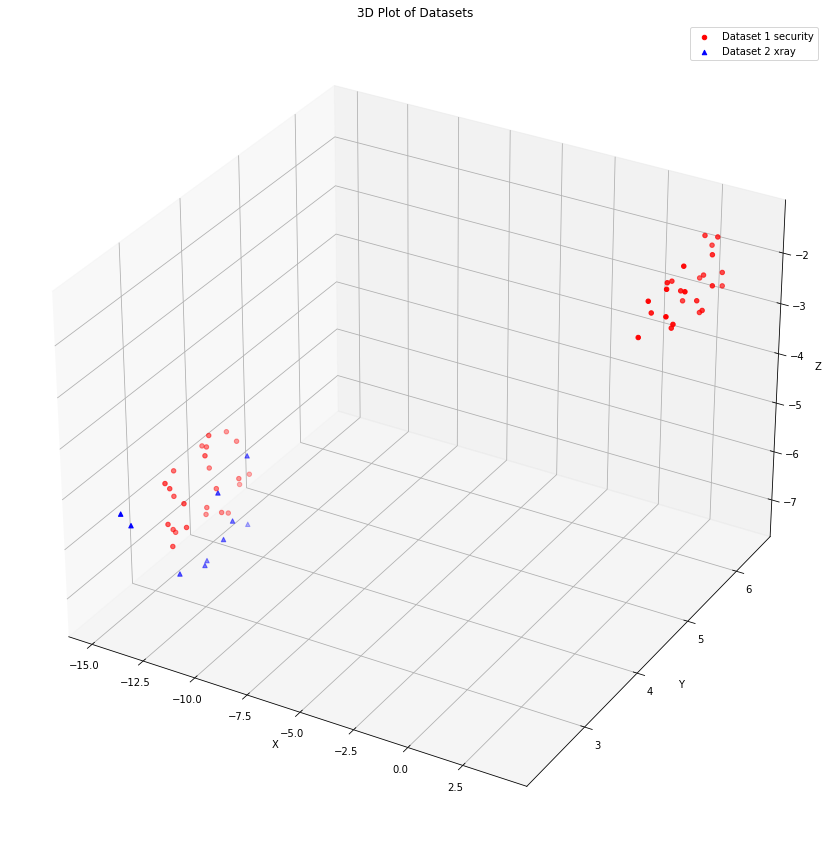

In [74]:
# Get labels
d1_label = data_dict_to_plot['datasets'][0]['datasetName']
d2_label = data_dict_to_plot['datasets'][1]['datasetName']

# Extract data points for each dataset
dataset1_points = data_dict_to_plot['datasets'][0]['points']
dataset2_points = data_dict_to_plot['datasets'][1]['points']


# Extract x, y, and z coordinates for each dataset
dataset1_x = [point['x'] for point in dataset1_points]
dataset1_y = [point['y'] for point in dataset1_points]
dataset1_z = [point['z'] for point in dataset1_points]

dataset2_x = [point['x'] for point in dataset2_points]
dataset2_y = [point['y'] for point in dataset2_points]
dataset2_z = [point['z'] for point in dataset2_points]

# Create the 3D plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Plot dataset 1 points
ax.scatter(dataset1_x, dataset1_y, dataset1_z, c='r', marker='o', label=f'Dataset 1 {d1_label}')

# Plot dataset 2 points
ax.scatter(dataset2_x, dataset2_y, dataset2_z, c='b', marker='^', label=f'Dataset 2 {d2_label}')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot title
ax.set_title('3D Plot of Datasets')

# Add legend
ax.legend()

# Show the plot
plt.show()